In [2]:
import pandas as pd
from statistics import *
from textblob import TextBlob
import numpy as np
import nltk
from nltk.corpus import stopwords
from collections import Counter 
import string
import seaborn as sns
nltk.download('stopwords')
stop_words = stopwords.words('english')

[nltk_data] Downloading package stopwords to /Users/nshah/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
df = pd.read_excel("AlexaReviews.xlsx")
sub_groups = {}
statistics = {}
alexa_variation = []

In [4]:
df.rename(columns = {'Variation ': 'Variation'}, inplace = True)
df['Variation'] = df['Variation'].str.replace("  ", " ")
df['Variation'] = df['Variation'].str.strip()
df['Verified_Reviews'] = df['Verified_Reviews'].str.replace("  ", " ")
df['Verified_Reviews'] = df['Verified_Reviews'].str.strip()
df['Verified_Reviews'] = df['Verified_Reviews'].str.replace('34', "")

In [5]:
#Replacing characters that are not needed
for i in string.punctuation:
        df['Verified_Reviews'] = df['Verified_Reviews'].str.replace(i, " ")
        df['Variation'] = df['Variation'].str.replace(i, '')



In [6]:
#finding the unique variations of alexa
for i in range (0, df.shape[0]):
    if df.iloc[i]['Variation'] not in alexa_variation:
        alexa_variation.append(df.iloc[i, 2])


In [7]:
#Creating Pandas DF with unique variations as the index        
rating_correlation = pd.DataFrame(index = alexa_variation, columns = ('Subjectivity', 'Polarity'))

# Store the counts of each type of variation
variation_counts = pd.value_counts(df.Variation)


In [8]:
#findRange function
def findRange(a):
    return max(a) - min(a)


In [9]:
for i in alexa_variation:
    # creates a new pandas object and adds to the dictionary under the variation name
    sub_groups[i] = (df.loc[df['Variation'] == i])
    
    tempList = []
    tempList2 = []
    
    # getting HTTP error because the service is unavailable, uncomment line below to see if it is working
    #comment this line to test if translation is working
    #sub_groups[i]['Verified_Reviews'].apply(lambda x: np.NaN if pd.isnull(x) else tempList.append(TextBlob(x).translate(from_lang = 'auto', to = 'en').Polarity[0]))

    #word counts
    together = "".join(sub_groups[i]['Verified_Reviews'])
    together = together.lower()

    #tokenizing words
    tokenized = together.split()
    
    filtered_sentence = []
    
    for w in tokenized: 
        if w not in stop_words: 
            filtered_sentence.append(w)
            
    # going through each verified reviews per variation, and adding the sentiment of it to a tempList to calc later
    sub_groups[i]['Verified_Reviews'].apply(lambda x: np.NaN if pd.isnull(x) else tempList.append(TextBlob(x).sentiment[0]))
    sub_groups[i]['Verified_Reviews'].apply(lambda x: np.NaN if pd.isnull(x) else tempList2.append(TextBlob(x).sentiment[1]))
    
    #Adding polarity and subjectivity per group
    sub_groups[i]['Polarity'] = tempList
    sub_groups[i]['Subjectivity'] = tempList2
    
    # Storing all stats in dictionary by variation
    statistics[i] = {'Rating': {
                        'mean' : mean(sub_groups[i]['Rating']),
                        'min' : min(sub_groups[i]['Rating']),
                        'max' : max(sub_groups[i]['Rating']),
                        'range' : findRange(sub_groups[i]['Rating']),
                        'std' : stdev(sub_groups[i]['Rating']),
                                },
                    'Polarity' : {
                        'mean' : mean(tempList),
                        'min' : min(tempList),
                        'max' : max(tempList),
                        'range' : findRange(tempList),
                        'std' : stdev(tempList)
                            },
                    'Subjectivity' : {
                        'mean' : mean(tempList2),
                        'min' : min(tempList2),
                        'max' : max(tempList2),
                        'range' : findRange(tempList2),
                        'std' : stdev(tempList2)
                            },
                    'Feedback' : {
                                'positive' : sub_groups[i].loc[sub_groups[i]['Feedback'] == 1].shape[0],
                                'negative' : sub_groups[i].loc[sub_groups[i]['Feedback'] == 0].shape[0],
                            },
                    'Correlation' : {
                                'rating_subj' : sub_groups[i][['Rating', 'Subjectivity']].corr(),
                                'rating_pol' : sub_groups[i][['Rating', 'Polarity']].corr()
                            },
                    'Word_Counts' : dict(Counter(filtered_sentence).most_common(30)),
                    
                    'Count' : variation_counts[i]
                }
                    
    statistics[i]['Feedback']['none'] = variation_counts[i] - (statistics[i]['Feedback']['positive'] + statistics[i]['Feedback']['negative'])
    
    rating_correlation.loc[i]['Subjectivity'] = statistics[i]['Correlation']['rating_subj'].iloc[0][1]
    rating_correlation.loc[i]['Polarity'] = statistics[i]['Correlation']['rating_pol'].iloc[0][1]


/Users/nshah/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/nshah/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [10]:
ratingStats = pd.DataFrame()
polarityStats = pd.DataFrame()
subjectivityStats = pd.DataFrame()
feedbackStats = pd.DataFrame()

for i in alexa_variation:
    ratingStats = ratingStats.append(pd.DataFrame(statistics[i]['Rating'], index = [i]))
    polarityStats = polarityStats.append(pd.DataFrame(statistics[i]['Polarity'], index = [i]))
    feedbackStats = feedbackStats.append(pd.DataFrame(statistics[i]['Feedback'], index = [i]))
    subjectivityStats = subjectivityStats.append(pd.DataFrame(statistics[i]['Subjectivity'], index = [i]))
    
# adding counts to each pd.df we export
ratingStats['count'] = variation_counts
polarityStats['count'] = variation_counts
feedbackStats['count'] = variation_counts
subjectivityStats['count'] = variation_counts
rating_correlation['count'] = variation_counts


In [11]:
with pd.ExcelWriter('IS_340_project_stats.xlsx') as writer:
    ratingStats.to_excel(writer, sheet_name='rating_stats')
    polarityStats.to_excel(writer, sheet_name='polarity_stats')
    feedbackStats.to_excel(writer, sheet_name='feedback_stats')
    subjectivityStats.to_excel(writer, sheet_name='subjectivity_stats')
    
#writing worcounts to excel file 
with pd.ExcelWriter('IS_340_word_stats.xlsx') as writer:    
    for i in alexa_variation:
        tempDF = pd.DataFrame.from_dict(statistics[i]['Word_Counts'], orient='index')
        tempDF.to_excel(writer, sheet_name = i)
        
rating_correlation.to_excel('Correlation_to_SubjPolarity.xlsx')


In [12]:
corr_polarityStats = polarityStats.loc[:].corr()
corr_feedbackStats = feedbackStats.loc[:].corr()
corr_subjectivityStats = subjectivityStats.loc[:].corr()
corr_ratingStats = ratingStats.loc[:].corr()


In [21]:
polarityStats

,mean,min,max,range,std,count
Charcoal Fabric,0.371037,-0.750,1.00,1.750,0.297278,430
Walnut Finish,0.336111,-0.400,0.65,1.050,0.327362,9
Heather Gray Fabric,0.365667,-0.650,1.00,1.650,0.283901,157
Sandstone Fabric,0.373837,-0.750,1.00,1.750,0.338834,90
Oak Finish,0.232143,-0.100,0.50,0.600,0.249119,14
Black,0.304329,-1.000,1.00,2.000,0.322105,259
White,0.325807,-0.910,1.00,1.910,0.361082,91
Black Spot,0.289077,-0.800,1.00,1.800,0.320401,241
White Spot,0.335411,-0.150,1.00,1.150,0.279582,109
Black Show,0.352918,-0.500,1.00,1.500,0.285278,265


In [22]:
subjectivityStats

,mean,min,max,range,std,count
Charcoal Fabric,0.539974,0.0,1.000,1.000,0.262213,430
Walnut Finish,0.623333,0.4,1.000,0.600,0.236022,9
Heather Gray Fabric,0.534793,0.0,1.000,1.000,0.258672,157
Sandstone Fabric,0.558425,0.0,1.000,1.000,0.301944,90
Oak Finish,0.346429,0.0,0.625,0.625,0.269054,14
Black,0.475722,0.0,1.000,1.000,0.290807,259
White,0.482663,0.0,1.000,1.000,0.300911,91
Black Spot,0.514739,0.0,1.000,1.000,0.270519,241
White Spot,0.532352,0.0,1.000,1.000,0.298450,109
Black Show,0.504036,0.0,1.000,1.000,0.286130,265


In [23]:
ratingStats

,mean,min,max,range,std,count
Charcoal Fabric,4.730233,1,5,4,0.683994,430
Walnut Finish,4.888889,4,5,1,0.333333,9
Heather Gray Fabric,4.694268,2,5,3,0.647108,157
Sandstone Fabric,4.355556,1,5,4,0.997875,90
Oak Finish,4.857143,4,5,1,0.363137,14
Black,4.231660,1,5,4,1.344095,259
White,4.142857,1,5,4,1.464934,91
Black Spot,4.311203,1,5,4,1.247764,241
White Spot,4.311927,1,5,4,1.222454,109
Black Show,4.490566,1,5,4,0.996635,265


In [24]:
rating_correlation

,Subjectivity,Polarity,count
Charcoal Fabric,0.0389003,0.368116,430
Walnut Finish,0.35484,0.843231,9
Heather Gray Fabric,0.156551,0.488245,157
Sandstone Fabric,0.25214,0.249537,90
Oak Finish,-0.438645,-0.327978,14
Black,0.211715,0.388578,259
White,0.293885,0.546087,91
Black Spot,0.161122,0.371171,241
White Spot,0.249939,0.396419,109
Black Show,0.145303,0.254738,265


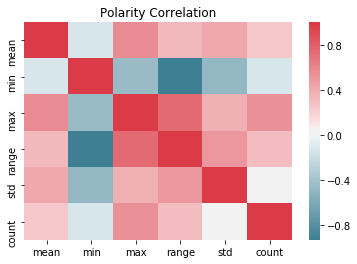

In [15]:
corr_polarityStats_plot = sns.heatmap(corr_polarityStats, xticklabels=corr_polarityStats.columns, 
                                    yticklabels=corr_polarityStats.columns, cmap=sns.diverging_palette(220, 10, as_cmap=True))
corr_polarityStats_plot.set_title('Polarity Correlation').get_figure().savefig(fname = 'Polarity Correlation.png', dpi = 500, pad = .9)

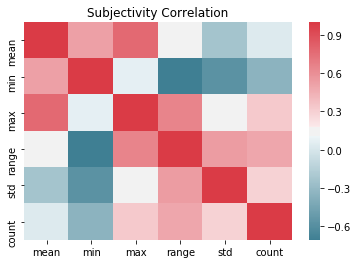

In [16]:
corr_subjectivityStats_plot = sns.heatmap(corr_subjectivityStats, xticklabels=corr_subjectivityStats.columns, 
                                    yticklabels=corr_subjectivityStats.columns, cmap=sns.diverging_palette(220, 10, as_cmap=True))
corr_subjectivityStats_plot.set_title('Subjectivity Correlation').get_figure().savefig(fname = 'Subjectivity Correlation.png', dpi = 500, pad = .9)

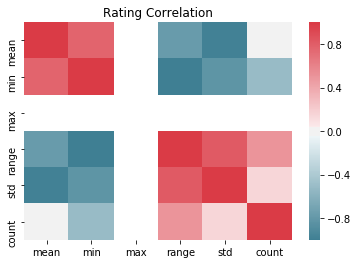

In [17]:
corr_ratingStats_plot = sns.heatmap(corr_ratingStats, xticklabels=corr_ratingStats.columns, 
                                    yticklabels=corr_ratingStats.columns, cmap=sns.diverging_palette(220, 10, as_cmap=True))
corr_ratingStats_plot.set_title('Rating Correlation').get_figure().savefig(fname = 'Rating Correlation.png', dpi = 500, pad = .9)



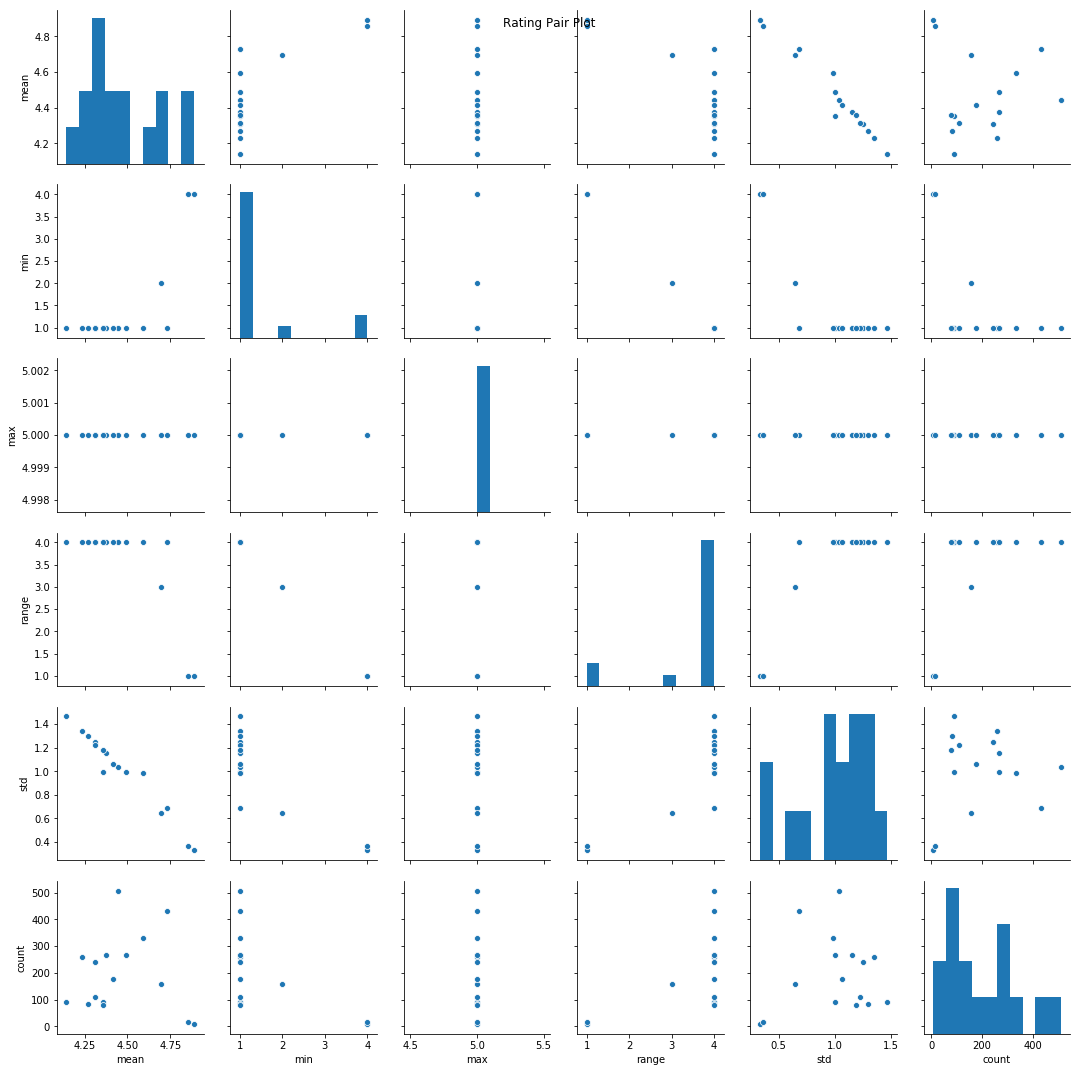

In [18]:
pairplot_ratingStats = sns.pairplot(ratingStats)
pairplot_ratingStats.fig.suptitle("Rating Pair Plot")
pairplot_ratingStats.savefig(fname = 'Rating pairplot.png', dpi = 500, pad = .9)

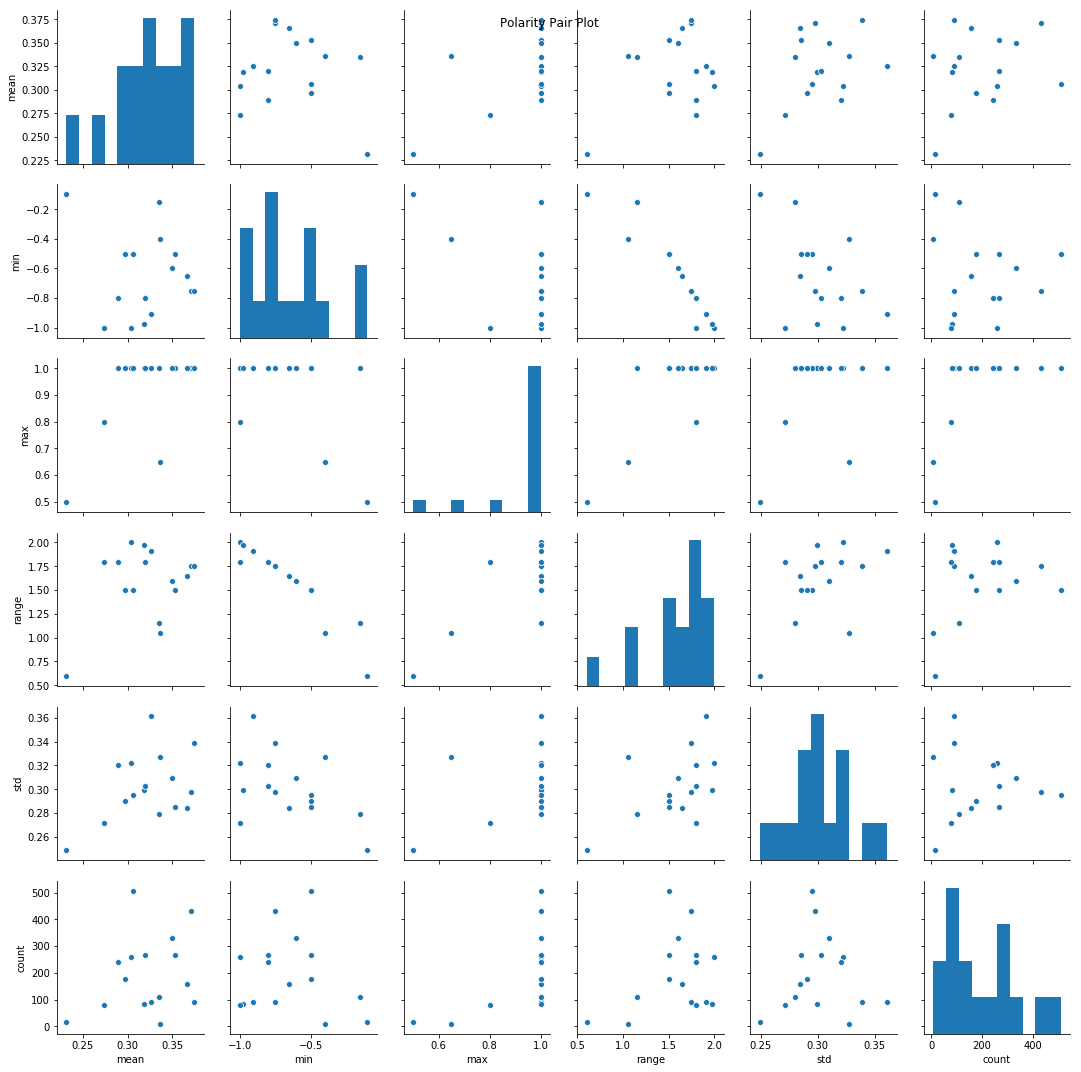

In [19]:
pairplot_polarityStats = sns.pairplot(polarityStats)
pairplot_polarityStats.fig.suptitle("Polarity Pair Plot")
pairplot_polarityStats.savefig(fname = 'Polarity pairplot.png', dpi = 500, pad = .9)

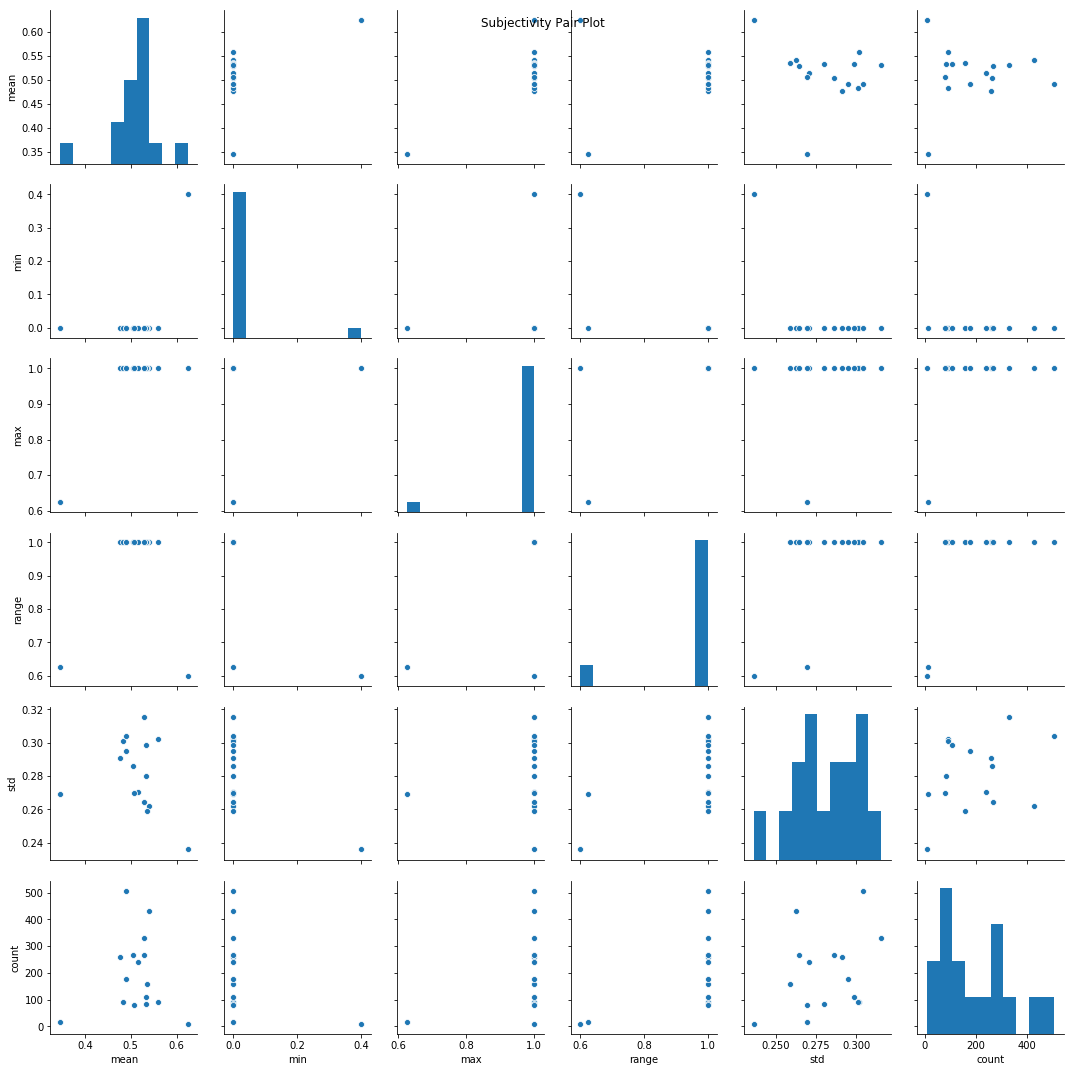

In [20]:
pairplot_subjectivityStats = sns.pairplot(subjectivityStats)
pairplot_subjectivityStats.fig.suptitle("Subjectivity Pair Plot")
pairplot_subjectivityStats.savefig(fname = 'Subjectivity pairplot.png', dpi = 500, pad = .9)